In [15]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, RepeatedKFold;

In [16]:
# load in train and test datasets
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

#Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [17]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x) == float else 1)

#Feature engineering
#Create new feature FamilySize as a combination of sibsp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone' ] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in full_data:
    dataset['Fare']= dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define the function to extract titles from passengers' names 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don',
                                                 'Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(int)
    title_mapping = {"Mr":1 ,"Miss":2, "Mrs":3 ,"Master": 4 ,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1 ,'Q':2}).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']  = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ (dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age' ] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
    

In [18]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


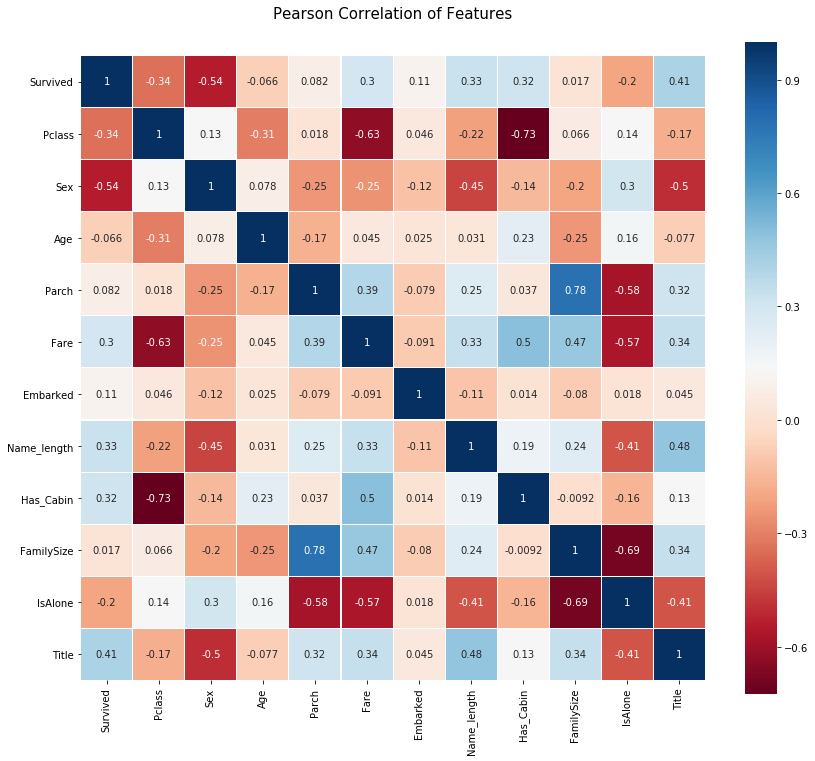

In [19]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [20]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)


In [21]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=False ,random_state=SEED) #K-交叉验证

#kf = RepeatedKFold(n_splits=NFOLDS, n_repeats =2 ,random_state=SEED) #K-交叉重复验证
def get_oof(clf, x_train, y_train, x_test):   #x_train 训练集 y_train 训练集标签 x_test测试集
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i,(train_index, test_index) in enumerate(kf.split(x_train)): #train_index 被分到训练集中的index  同理test_index
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te) # 用验证数据集验证训练集训练好的模型
        oof_test_skf[i, :] = clf.predict(x_test)  # 用测试集测试
        print("K-fold: %d accuracy score is %f " % (i,accuracy_score(y_te.reshape(-1),clf.predict(x_te).reshape(-1))))
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)   

In [22]:
# Put in our parameters for said classifiers
# Forest note:
# the main parameters for these "forest" algorithm is 'n_estimators' and 'max_features'
# Random Forest parameters
rf_params = {
    'n_jobs': -1,                # the number of jobs to run in parallel for both fit and predict
    'n_estimators': 1200,         # The number of trees in the forest
     #'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 20,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',    # the max number of features to consider when looking for the best split
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':1200,
    #'warm_start': True,
    #'max_features': 0.5,
    'max_depth': 20,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 1200,
    'learning_rate' : 0.1
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 900,
     #'max_features': 0.2,
    'max_depth': 15,
    'min_samples_leaf': 3,
    'verbose': 0
}

In [23]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'poly',
    'C' : 0.0453
    }

In [24]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [25]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [26]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

K-fold: 0 accuracy score is 0.804469 
K-fold: 1 accuracy score is 0.814607 
K-fold: 2 accuracy score is 0.837079 
K-fold: 3 accuracy score is 0.780899 
K-fold: 4 accuracy score is 0.876404 
K-fold: 0 accuracy score is 0.804469 
K-fold: 1 accuracy score is 0.808989 
K-fold: 2 accuracy score is 0.837079 
K-fold: 3 accuracy score is 0.780899 
K-fold: 4 accuracy score is 0.870787 
K-fold: 0 accuracy score is 0.832402 
K-fold: 1 accuracy score is 0.814607 
K-fold: 2 accuracy score is 0.803371 
K-fold: 3 accuracy score is 0.792135 
K-fold: 4 accuracy score is 0.870787 
K-fold: 0 accuracy score is 0.787709 
K-fold: 1 accuracy score is 0.786517 
K-fold: 2 accuracy score is 0.825843 
K-fold: 3 accuracy score is 0.803371 
K-fold: 4 accuracy score is 0.848315 
K-fold: 0 accuracy score is 0.832402 
K-fold: 1 accuracy score is 0.825843 
K-fold: 2 accuracy score is 0.803371 
K-fold: 3 accuracy score is 0.775281 
K-fold: 4 accuracy score is 0.853933 
Training is complete


In [27]:
from sklearn.metrics import accuracy_score
#print(rf_oof_train.reshape(-1))
#print(accuracy_score(y_train,rf_oof_train.reshape(-1)))
print("rf:  %f" % (accuracy_score(y_train,rf.predict(x_train))))
print("et:  %f" % (accuracy_score(y_train,et.predict(x_train))))
print("ada: %f" % (accuracy_score(y_train,ada.predict(x_train))))
print("gb:  %f" % accuracy_score(y_train,gb.predict(x_train)))
print("svc: %f" % accuracy_score(y_train,svc.predict(x_train)))
# print(rf.predict(x_train))
# print(accuracy_score(y_train,et_oof_train.reshape(-1)))
# print(accuracy_score(y_train,ada_oof_train.reshape(-1)))
# print(accuracy_score(y_train,gb_oof_train.reshape(-1)))
# print(accuracy_score(y_train,svc_oof_train.reshape(-1)))

rf:  0.894501
et:  0.893378
ada: 0.842873
gb:  0.940516
svc: 0.833895


In [28]:
train['train_predict']=rf.predict(x_train)+et.predict(x_train)+ada.predict(x_train)+gb.predict(x_train)+svc.predict(x_train)
train['train_predict']=train['train_predict'].astype('int')
#print(train.head(10))

train.loc[ train['train_predict'] < 3, 'train_predict' ] = 0
train.loc[ train['train_predict'] >= 3, 'train_predict' ] = 1
train.head(10)
print(accuracy_score(y_train,train['train_predict'].ravel()))
#直接某个基学习器
#print(rf_oof_test.round())
# StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
#                              'Survived': gb.predict(x_test)})
# StackingSubmission.to_csv("GBSubmission.csv", index=False)

0.892255892256


In [29]:
prediction=rf.predict(x_test)+et.predict(x_test)+ada.predict(x_test)+gb.predict(x_test)+svc.predict(x_test)
print(prediction)
prediction=[1 if x >=3 else 0 for x in prediction]
print(prediction)
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': prediction })
StackingSubmission.to_csv("EnsemleSubmission.csv", index=False)

[0 4 0 0 3 0 5 0 5 0 0 0 5 0 5 5 0 0 2 5 0 2 5 1 5 0 5 0 1 0 0 0 2 5 4 4 2
 3 0 1 0 0 0 4 5 0 2 0 5 5 1 0 5 4 1 0 0 0 0 5 0 0 0 4 5 5 5 0 1 4 5 0 2 1
 5 2 0 5 0 5 4 0 0 0 0 0 4 2 5 5 1 0 4 0 0 0 5 0 4 0 5 0 0 0 5 0 0 0 0 0 0
 5 5 5 5 0 0 5 0 5 5 0 5 0 0 3 0 5 1 0 1 2 0 0 0 0 1 0 3 0 0 5 0 0 5 0 1 0
 1 1 5 0 0 4 1 0 5 5 1 4 4 5 5 0 0 4 1 0 4 2 0 0 1 1 0 5 5 2 5 5 0 4 4 0 5
 0 5 0 0 0 0 0 5 0 5 0 5 3 0 2 4 5 4 5 0 1 5 0 5 0 0 0 0 5 0 0 5 0 5 0 5 0
 5 0 5 5 0 5 0 0 0 5 0 0 3 0 1 0 5 5 5 5 4 0 4 1 4 0 4 5 5 0 4 0 0 0 0 0 5
 0 0 0 5 5 1 0 1 0 2 0 1 0 5 5 0 5 0 0 0 0 5 4 5 5 5 0 0 0 0 0 0 5 0 3 0 0
 5 0 0 0 0 0 0 0 5 5 1 5 0 2 0 0 0 5 5 5 1 0 0 0 0 0 0 0 5 0 4 4 0 0 5 1 0
 5 0 2 0 0 0 1 0 0 0 5 4 4 0 5 0 5 5 0 0 0 5 0 5 0 0 5 0 5 5 0 5 0 0 3 5 1
 0 5 0 0 5 5 1 0 0 0 0 0 4 2 0 5 0 0 0 0 0 5 5 1 0 5 0 5 0 0 5 0 5 0 2 3 0
 0 5 4 5 5 5 1 5 0 0 4]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 

In [30]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [31]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 1000,
 max_depth= 5,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train,gbm.predict(x_train).reshape(-1).tolist()))

0.83950617284


In [33]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)